In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
savePath = f"../Results/logHenry/Prediction/LGBM/0.2.2_MRobust-2024-08-19_17.24.15_"
valData = pd.read_csv(f"../Data/Datasets/PredictionDatasets/0.2.2-logHenry-MRobust-ValidationSet.csv")
valPreds = pd.read_csv(f"{savePath}ValidationPreds.csv")

In [4]:
valData = valData[["logHenry", "InChI", "nIsomers", f"HenryConstant-dataSource", "Temperature"]]
valData

,logHenry,InChI,nIsomers,HenryConstant-dataSource,Temperature
0,11.561716,"InChI=1S/3C2H5.ClH.Pb/c3*1-2;;/h3*1H2,2H3;1H;/...",1.0,https://doi.org/10.5194/acp-23-10901-2023,0.0
1,14.936102,InChI=1S/3C6H11.C2H2N3.Sn/c3*1-2-4-6-5-3-1;1-3...,1.0,https://doi.org/10.5194/acp-23-10901-2023,0.0
2,-13.345507,"InChI=1S/4C4H9.Sn/c4*1-3-4-2;/h4*1,3-4H2,2H3;",1.0,https://doi.org/10.5194/acp-23-10901-2023,0.0
3,-11.042922,InChI=1S/4CH3.Pb/h4*1H3;,1.0,https://doi.org/10.5194/acp-23-10901-2023,0.0
4,8.496990,"InChI=1S/6C10H13.O.2Sn/c6*1-10(2,3)9-7-5-4-6-8...",1.0,https://doi.org/10.5194/acp-23-10901-2023,0.0
...,...,...,...,...,...
2534,-0.222781,InChI=1S/CO2/c2-1-3,1.0,https://doi.org/10.5194/acp-23-10901-2023,0.0
2535,-0.259324,InChI=1S/COS/c2-1-3,1.0,https://doi.org/10.5194/acp-23-10901-2023,0.0
2536,-5.930056,InChI=1S/CS2/c2-1-3,1.0,https://doi.org/10.5194/acp-23-10901-2023,0.0
2537,-0.634878,InChI=1S/H3N/h1H3,1.0,https://doi.org/10.5194/acp-23-10901-2023,0.0


In [5]:
def calcMSE(yTrue, yPred):
    mse = [mean_squared_error(yT, yP) for yT, yP in zip(yTrue, yPred)]
    return mse

def unlog(x):
    return np.exp(x)

In [6]:
valData.insert(1, "logHenryPreds", valPreds["yPred"])

yPred = valData["logHenryPreds"].values.reshape(-1, 1)
yTrue = valData["logHenry"].values.reshape(-1, 1)

mse = calcMSE(yTrue, yPred)

valData.insert(2, "MSE(log)", mse)

loggedR2 = r2_score(yTrue, yPred)
loggedMSE = mean_squared_error(yTrue, yPred)

In [7]:
yPredUnlogged = unlog(yPred)
yTrueUnlogged = unlog(yTrue)

valData.insert(3, "UnloggedHenryPreds", yPredUnlogged)
valData.insert(4, "UnloggedHenry", yTrueUnlogged)

mseUnlogged = calcMSE(yTrueUnlogged, yPredUnlogged)
valData.insert(5, "MSE(Henry)", mseUnlogged)


valData.to_csv(f"{savePath}ValidationMSE.csv", index=False)

In [8]:
overallR2 = r2_score(yTrueUnlogged, yPredUnlogged)
overallMSE = mean_squared_error(yTrueUnlogged, yPredUnlogged)

print("Logged R2: ", loggedR2)
print("Logged MSE: ", loggedMSE)
print("Unlogged R2: ", overallR2)
print("Unlogged MSE: ", overallMSE)

numEntries = valData.shape[0]
numErrorUnlogged = valData[valData["MSE(Henry)"] > 1]
numErrorLogged = valData[valData["MSE(log)"] > 1]

percentageErrorUnlogged = numErrorUnlogged.shape[0] / numEntries * 100
percentageErrorLogged = numErrorLogged.shape[0] / numEntries * 100
print("Percentage of entries with MSE > 1 (Unlogged): ", percentageErrorUnlogged)
print("Percentage of entries with MSE > 1 (Logged): ", percentageErrorLogged)

Logged R2:  0.6626903518361885
Logged MSE:  19.113500730135495
Unlogged R2:  -68.6738593787252
Unlogged MSE:  2.1343629017478697e+21
Percentage of entries with MSE > 1 (Unlogged):  52.934226073257186
Percentage of entries with MSE > 1 (Logged):  76.5261914139425


In [9]:
overallStats = pd.DataFrame([loggedR2, loggedMSE, overallR2, overallMSE, percentageErrorUnlogged, percentageErrorLogged]).T
overallStats.columns = ["LoggedR2", "LoggedMSE", "UnloggedR2", "UnloggedMSE", "PercentageErrorUnlogged", "PercentageErrorLogged"]

overallStats.to_csv(f"{savePath}OverallStats.csv", index=False)

In [10]:
def getExtremes(target, df, nVals, ascend):
    entries = df.sort_values(by=target, ascending=ascend).head(nVals)
    inchi = entries["InChI"].values.tolist()
    scores = entries[target].values.tolist()

    return inchi, scores

def listExpander(myList, nVals): #Fill in list to desired length with nans
    if type(myList) != list:
        myList = [myList]
    for i in range(nVals - len(myList)):
        myList.append(np.nan)
    return myList

In [11]:
ascending = [True, False]
extreme = ["Best", "Worst"]
n = 10

for i in range(len(ascending)):
    asc = ascending[i]
    UnloggedInChI, UnloggedMSE = getExtremes("MSE(Henry)", valData, n, asc)
    LoggedInChI, LoggedMSE = getExtremes("MSE(log)", valData, n, asc)

    stats = pd.DataFrame([UnloggedMSE, UnloggedInChI, LoggedMSE, LoggedInChI]).T
    stats.columns = ["MSE(Henry)", "InChI(Henry)", "MSE(logHenry)", "InChI(logHenry)"]

    overlap = list(set(UnloggedInChI) & set(LoggedInChI))
    overlap = listExpander(overlap, n)
    stats.insert(0, "Overlap", overlap)

    stats.to_csv(f"{savePath}{n}{extreme[i]}Entries.csv", index=False)

1195
2539
0.9813570437872132


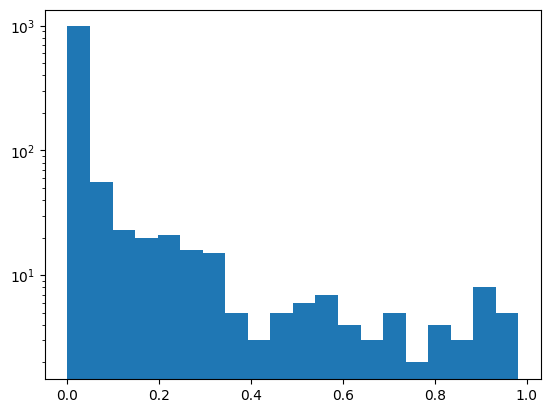

In [24]:
toHist = valData[valData["MSE(Henry)"] < 1]
print(len(toHist))
print(len(valData))
print(np.max(toHist["MSE(Henry)"]))

fig, ax = plt.subplots()
ax.hist(toHist["MSE(Henry)"], bins=20)
ax.set_yscale("log")
plt.show()

596
0.9877983193670686


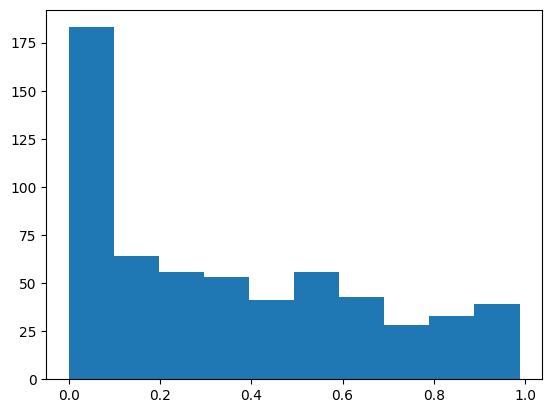

In [18]:
toHist = valData[valData["MSE(log)"] < 1]
print(len(toHist))
print(np.max(toHist["MSE(log)"]))
plt.hist(toHist["MSE(log)"], bins=10)
plt.show()